In [41]:
import os
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import glob
import re
from scipy.special import gamma
import matplotlib.pyplot as plt
from collections import defaultdict


spe_files = glob.glob('PMT1_SPE_CLEAN/*.csv')

print("SPE files found:")
for f in spe_files:
    print(" ", f)

SPE files found:
  PMT1_SPE_CLEAN/081225_spe_1750_2500_1_on_ch1_processed_cleaned.csv
  PMT1_SPE_CLEAN/091225_spe_1850_2500_1_on_ch1_processed_cleaned.csv
  PMT1_SPE_CLEAN/091225_spe_1950_2500_2_on_ch1_processed_cleaned.csv
  PMT1_SPE_CLEAN/081225_spe_1800_2500_1_on_ch1_processed_cleaned.csv
  PMT1_SPE_CLEAN/091225_spe_2000_2500_1_on_ch1_processed_cleaned.csv
  PMT1_SPE_CLEAN/091225_spe_1750_2500_1_on_ch1_processed_cleaned.csv
  PMT1_SPE_CLEAN/091225_spe_1900_2500_2_on_ch1_processed_cleaned.csv


In [42]:
def get_voltage(filepath):
    filename = os.path.basename(filepath)
    match = re.search(r'_(\d{3,4})_', filename)
    return int(match.group(1))


def collect_charge_by_voltage(file_list):
    """
    Groups all integral_pC values by voltage and concatenates them.
    Returns dict: voltage -> np.array(all charges)
    """
    voltage_dict = defaultdict(list)

    for file in file_list:
        voltage = get_voltage(file)
        df = pd.read_csv(file)
        charge = df['integral_pC'].values
        voltage_dict[voltage].append(charge)

    # concatenate per voltage
    for v in voltage_dict:
        voltage_dict[v] = np.concatenate(voltage_dict[v])

    return voltage_dict

In [43]:
def polya_dist(positive_charge_data, A, nbar, theta):
    # A = amplitude / normalisation
    polya_PMF = A*((theta + 1)**(theta + 1))*(1/gamma(theta + 1))*((positive_charge_data/nbar)**theta)*np.exp(-(theta + 1)*(positive_charge_data/nbar))
    return polya_PMF


def fit_polya_and_get_peak(all_integrals_picocharge, bin_cut, Delta_x=0.1, filename=None):

    # keep only positive charges
    positive_charge_data = all_integrals_picocharge[all_integrals_picocharge > 0]

    # histogram
    int_number_of_bins = int((np.max(positive_charge_data) - np.min(positive_charge_data)) / Delta_x)
    n, bins = np.histogram(positive_charge_data, bins=int_number_of_bins)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # apply fit cut
    mask = bin_centers >= bin_cut
    n_fit = n[mask]
    bin_centers_fit = bin_centers[mask]

    positive_charge_data_cut = positive_charge_data[positive_charge_data >= bin_cut]

    # initial guesses
    initial_nbar = np.mean(positive_charge_data_cut)
    initial_var = np.var(positive_charge_data_cut)
    N_events = len(positive_charge_data)

    initial_A = N_events * Delta_x
    initial_theta = np.abs((initial_nbar**2 / initial_var) - 1)

    p0 = [initial_A, initial_nbar, initial_theta]

    sigma=np.sqrt(n_fit)
    #print(np.sqrt(n_fit))
    sigma[sigma==0.0] = 1

    # fit
    popt, pcov = curve_fit(
        polya_dist,
        bin_centers_fit,
        n_fit,
        p0=p0,
        sigma=sigma,
        absolute_sigma=True,
        maxfev=10000
    )

    A_fit, nbar_fit, theta_fit = popt
    err_A = np.sqrt(pcov[0, 0])
    err_nbar = np.sqrt(pcov[1, 1])
    err_theta = np.sqrt(pcov[2, 2])

    # peak position
    peak = (theta_fit / (theta_fit + 1)) * nbar_fit

    dpeak_dnbar = theta_fit / (theta_fit + 1)
    dpeak_dtheta = nbar_fit / (theta_fit + 1)**2

    peak_err = np.sqrt(
        (dpeak_dnbar * err_nbar)**2 +
        (dpeak_dtheta * err_theta)**2 +
        2*dpeak_dnbar*dpeak_dtheta*pcov[1,2]
    )

    # chi^2
    model_fit = polya_dist(bin_centers_fit, *popt)
    valid = n_fit > 0
    chi2 = np.sum((n_fit[valid] - model_fit[valid])**2 / n_fit[valid])
    ndof = np.sum(valid) - len(popt)
    chi2_red = chi2 / ndof

    if peak_err == np.inf:
        peak_err=-100
    # plot
    plt.figure(figsize=(6,6))
    plt.bar(bin_centers, n, width=Delta_x, alpha=0.6, label='Data')

    x_fit = np.linspace(bin_cut, np.max(bin_centers), 600)
    plt.plot(x_fit, polya_dist(x_fit, *popt), 'r-', lw=2,
             label=rf'Polya fit, $\chi^2_\nu={chi2_red:.2f}$')

    plt.axvline(peak, color='k', linestyle='--',
                label=rf'Peak = ${peak:.3f}\pm{peak_err:.3f}$ pC')

    plt.xlim(0, np.max(bin_centers))
    plt.xlabel('Charge (pC)')
    plt.ylabel('Counts')

    if filename is not None:
        plt.title(filename)
    else:
        plt.title('Polya fit to pulse integral histogram')

    plt.legend()
    plt.tight_layout()
    plt.show()

    return peak, peak_err

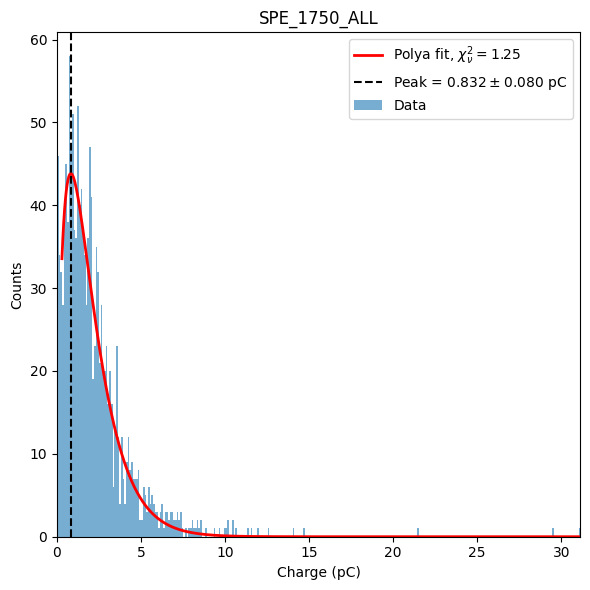

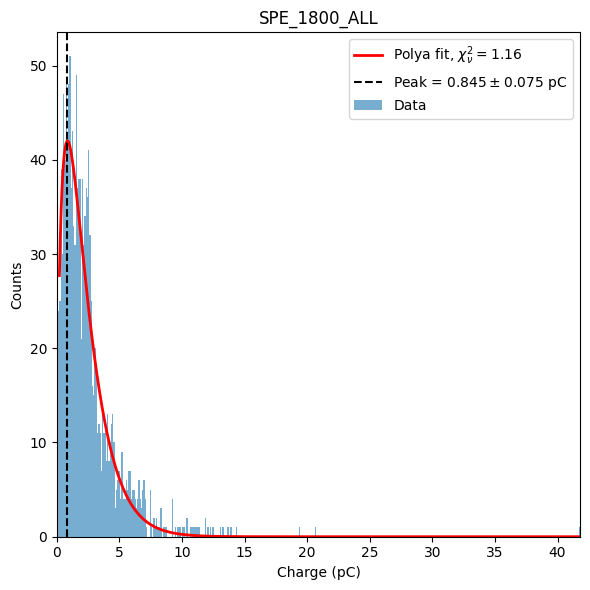

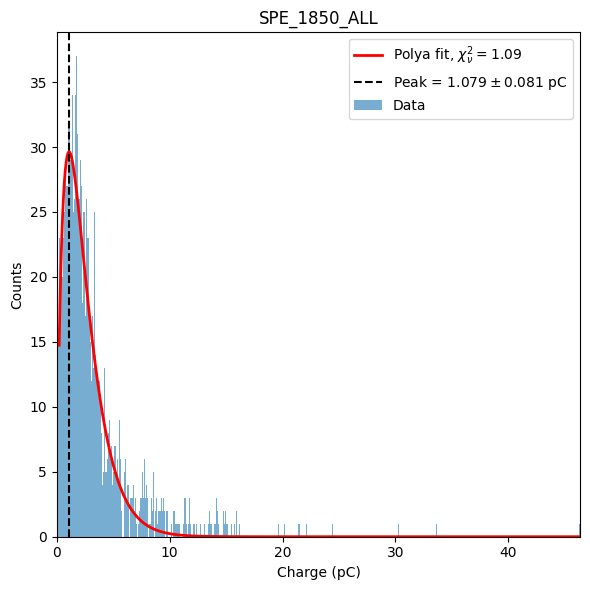

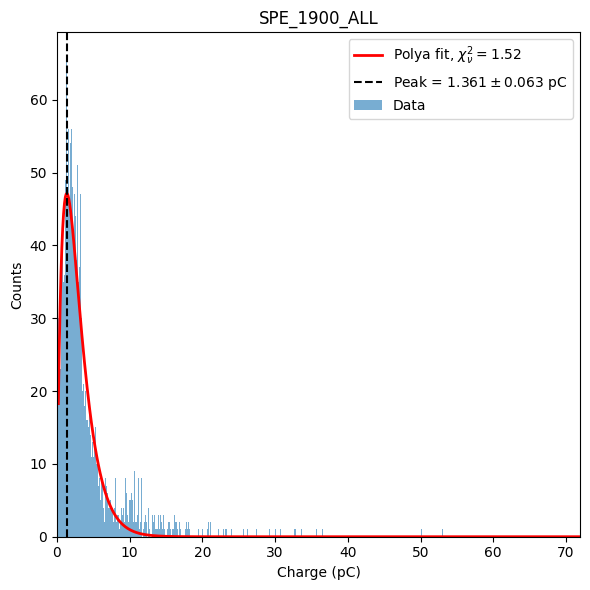

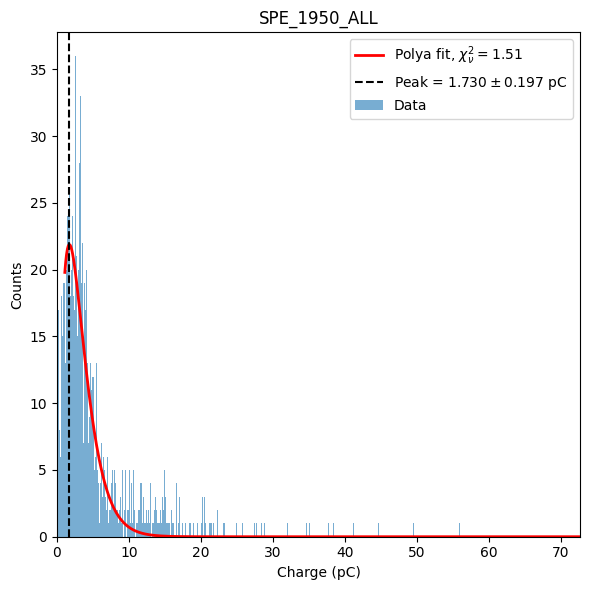

/var/folders/54/shy8r4g15d33hf9px0m5hytc0000gn/T/ipykernel_88146/1042477713.py:3: RuntimeWarning: invalid value encountered in power
  polya_PMF = A*((theta + 1)**(theta + 1))*(1/gamma(theta + 1))*((positive_charge_data/nbar)**theta)*np.exp(-(theta + 1)*(positive_charge_data/nbar))


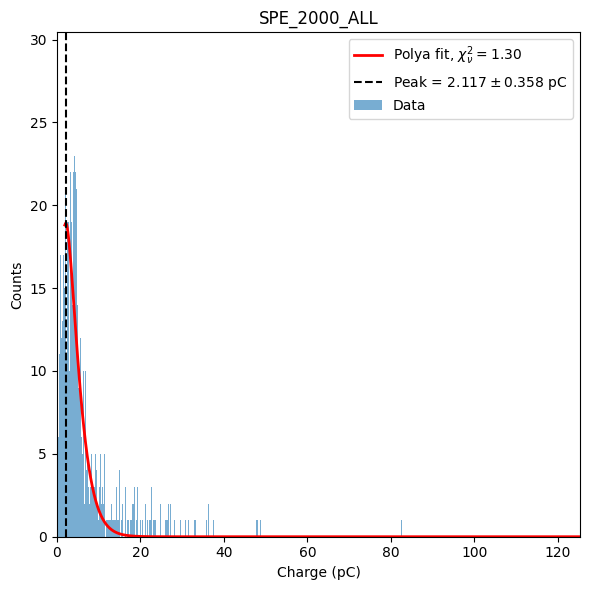

CSV file outputted successfully!


In [44]:
spe_results = []

spe_voltage_data = collect_charge_by_voltage(spe_files)

for voltage in sorted(spe_voltage_data.keys()):
    charge = spe_voltage_data[voltage]

    if voltage == 2000:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut=1.9, filename=f"SPE_{voltage}_ALL")
    if voltage == 1950:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut=1.1, filename=f"SPE_{voltage}_ALL")
    if voltage == 1900:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut=0.2, filename=f"SPE_{voltage}_ALL")
    if voltage == 1850:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut=0.2, filename=f"SPE_{voltage}_ALL")
    if voltage == 1800:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut=0.2, filename=f"SPE_{voltage}_ALL")
    if voltage == 1750:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut=0.3, filename=f"SPE_{voltage}_ALL")

    spe_results.append({
        'voltage': voltage,
        'polya_peak_pC': peak,
        'polya_peak_error_pC': peak_err
    })

spe_df = pd.DataFrame(spe_results)
spe_df.sort_values('voltage', inplace=True)
spe_df.to_csv('PMT1_spe_COMBINED_polya_peak_positions2.csv', index=False)


print('CSV file outputted successfully!')